In [77]:
import qiskit
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.visualization import circuit_drawer, plot_bloch_multivector, plot_histogram
from qiskit.visualization import array_to_latex
from qiskit.quantum_info import random_statevector
#from qiskit.extensions import initialize
from math import pi, sqrt
import pylatexenc
from pylatexenc.latex2text import LatexNodes2Text

#  Quantum Teleportation with Qiskit

In [78]:
# psi is our unknown state
# we will get a random state
# whenever we run this cell we will get a new value
psi = random_statevector(2) # because each qubit has two elements

print('psi state: {}'.format(psi))

array_to_latex(psi)

psi state: Statevector([0.75361044+0.19149571j, 0.49139083+0.39234648j],
            dims=(2,))


<IPython.core.display.Latex object>

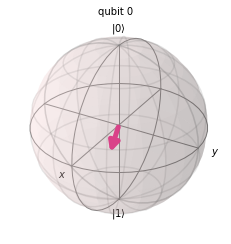

In [79]:
plot_bloch_multivector(psi)



## our goal is to teleport the above state

In [80]:
# corrected code without [from qiskit.extensions import initialize]
# qc = QuantumCircuit(1)
# init_state = qc.initialize(psi.data, 0)


#course code which is not working:
#init_state = Initialize(psi)
#init_state.label = "initial_state"
# label is not working here

In [81]:
# we are defining four functions according to the four steps of teleportation
# Step 1. create Bell State (entanglement) between Alice (a) and Bob (b)
def create_bell_pair(qc,a, b):
    qc.h(a) # a belongs to Alice
    qc.cx(a,b)

In [82]:
# Step 2
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [83]:
# Step 3
def measure_and_send (qc, a,b):
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)    

In [84]:
# Step 4
# we define two classical register crz, and crx which are received from Alice
# we define one qubit which is Bob's unknown qubit
#c_if is classical if statement
def bob_gates(qc, qubit, crz, crx):
    qc.x(qubit).c_if(crx,1)
    qc.z(qubit).c_if(crz,1)

# Construct our teleportation state

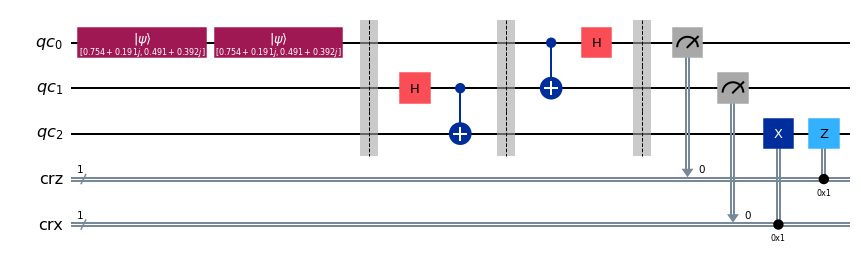

In [85]:
qr = QuantumRegister(3, name = "qc") # have three qubits
crz = ClassicalRegister(1, name = "crz")
crx = ClassicalRegister(1, name = "crx")
qc = QuantumCircuit(qr, crz, crx)

init_state = qc.initialize(psi, 0)
qc.initialize(psi.data, 0)
qc.barrier()

create_bell_pair(qc, 1, 2)
qc.barrier()

alice_gates(qc, 0, 1)

measure_and_send(qc, 0, 1)

bob_gates(qc, 2, crz, crx)

qc.draw('mpl')


 Quantum state is:  Statevector([ 0.   +0.j   ,  0.   -0.j   ,  0.   +0.j   ,  0.683+0.371j,
             -0.   +0.j   , -0.   +0.j   , -0.   +0.j   ,  0.38 +0.501j],
            dims=(2, 2, 2))


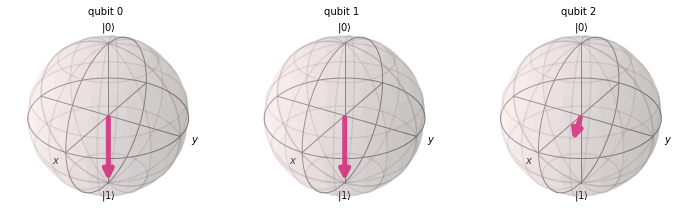

In [86]:
backend = Aer.get_backend('statevector_simulator')

q_teleport = transpile (qc, backend) 
job = backend.run(q_teleport)

result = job.result().get_statevector(qc, decimals = 3)

print("\n Quantum state is: ", result)

plot_bloch_multivector(result)

# Superdense Coding

In [87]:
def create_bell_pair1(qc, a,b):
    qc.h(a)
    qc.cx(a,b)

In [88]:
def encode_message(qc, qubit, msg):
    if msg == "00":
        pass  #identity gate will be applied
    elif msg == "10":
        qc.x(qubit)
    elif msg == "01":
        qc.z(qubit)
    elif msg == "11":
        qc.z(qubit)
        qc.x(qubit)
    else:
        print("invalid message. Sending '00'")

In [89]:
def decode_message(qc,a,b):
    qc.cx(a,b)
    qc.h(a)

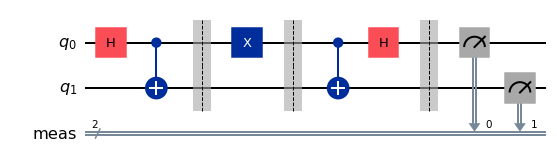

In [90]:
qc = QuantumCircuit(2)

create_bell_pair(qc, 0,1)
qc.barrier()

message = "10"

encode_message(qc, 0, message)
qc.barrier()

decode_message(qc, 0, 1)

qc.measure_all() # that is why we didn't define QuantumCircuit(2,2)
qc.draw('mpl')


 Total counts are:  {'10': 1000}


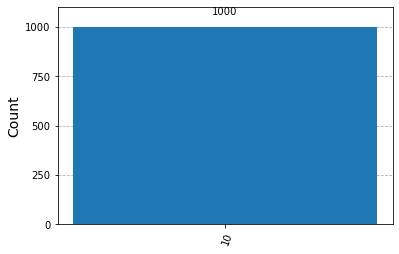

In [91]:
backend = Aer.get_backend('qasm_simulator')

q_seuperdense = transpile (qc, backend) 
job = backend.run(q_seuperdense, shots = 1000)

result = job.result()

counts = result.get_counts(qc)

print("\n Total counts are: ", counts)

plot_histogram(counts)